In [1]:
import scipy.io.arff as arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pywt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data, meta = arff.loadarff('/Users/dmitrykorzhov/Desktop/Root/projects/bci_stuff/EEG Eye State.arff')

data = pd.DataFrame(data)

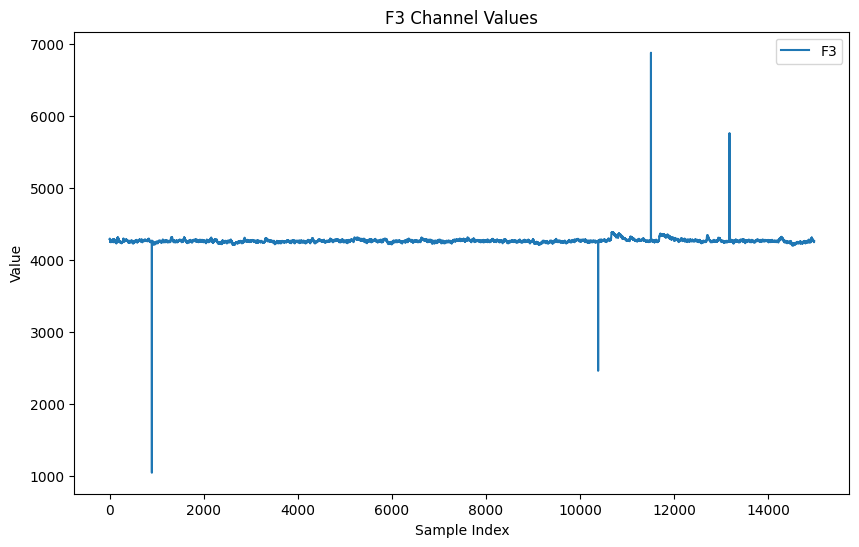

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(data['F3'], label='F3')
plt.title('F3 Channel Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

## Data Preprocessing

- Z-transfrom 
- IQR normalization
- Moving average
- Applying low-pass filter to remove high-frequency noise
- Applying morlet wavelet transform 

In [4]:
data['eyeDetection'] = data['eyeDetection'].apply(lambda x: 0 if x == b'0' else 1)

In [5]:
eyeBlinked = data[data['eyeDetection'] == 1]

In [6]:
eyeNotBlinked = data[data['eyeDetection'] == 0]

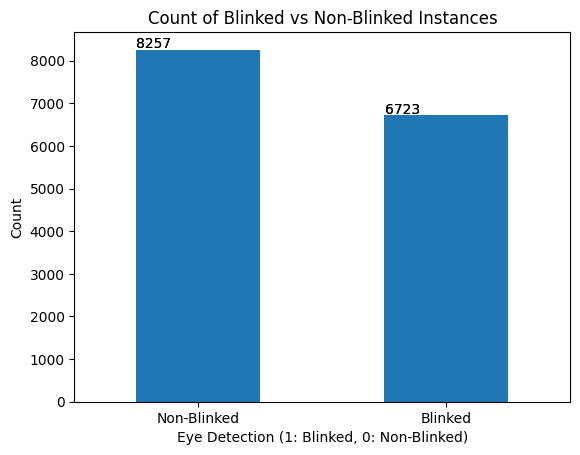

In [3]:
eyeDetection_counts = data['eyeDetection'].value_counts()
eyeDetection_counts.plot(kind='bar')
ax = eyeDetection_counts.plot(kind='bar')
plt.title('Count of Blinked vs Non-Blinked Instances')
plt.xlabel('Eye Detection (1: Blinked, 0: Non-Blinked)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Blinked', 'Blinked'], rotation=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

### Applying Z-transform reduce data range

In [7]:
numeric_cols = data.columns.drop('eyeDetection')
data[numeric_cols] = data[numeric_cols].apply(zscore)

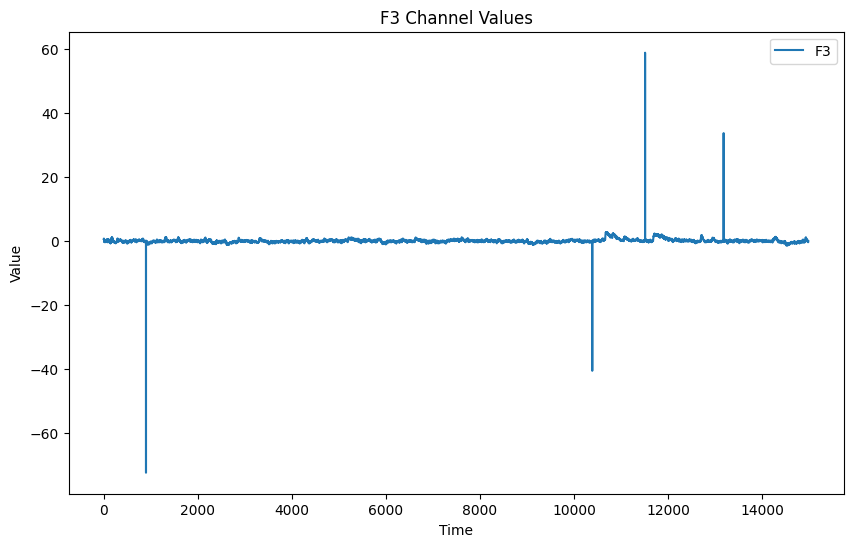

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(data['F3'], label='F3')
plt.title('F3 Channel Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Applying IQR to remove outliers

In [8]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [9]:
filtered_data = data.copy()
for column in numeric_cols:
    filtered_data = remove_outliers(filtered_data, column)

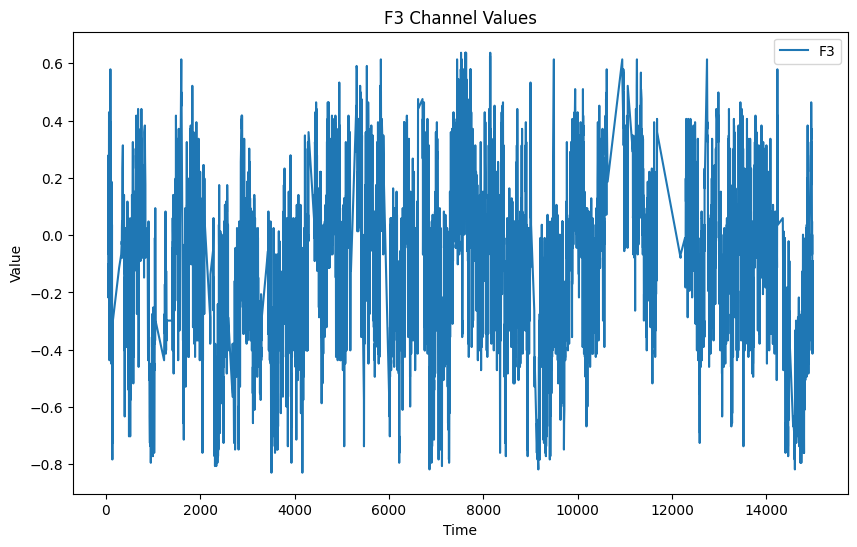

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['F3'], label='F3')
plt.title('F3 Channel Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

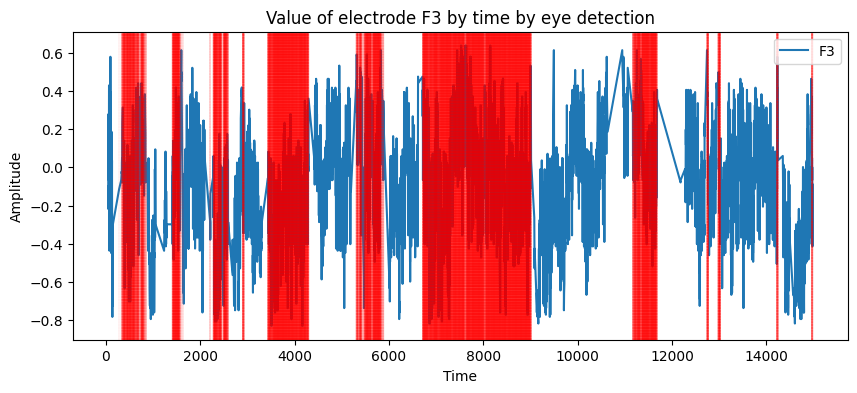

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_data['F3'], label='F3')

blink_indices = filtered_data[filtered_data['eyeDetection'] == 1].index

for blink_index in blink_indices:
    plt.axvline(x=blink_index, color='red', linestyle='--', lw=0.1)

plt.title('Value of electrode F3 by time by eye detection')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Applying moving average to reduce noise and smoothen data

In [10]:
window_size = 120

filtered_data_ma = filtered_data.copy()
for column in numeric_cols:
    filtered_data_ma[column] = filtered_data[column].rolling(window=window_size).mean()

In [11]:
nan_counts = filtered_data_ma.isnull().sum()
print(nan_counts)

AF3             119
F7              119
F3              119
FC5             119
T7              119
P7              119
O1              119
O2              119
P8              119
T8              119
FC6             119
F4              119
F8              119
AF4             119
eyeDetection      0
dtype: int64


In [12]:
filtered_data_ma = filtered_data_ma.dropna()

nan_counts_after_dropping = filtered_data_ma.isnull().sum()

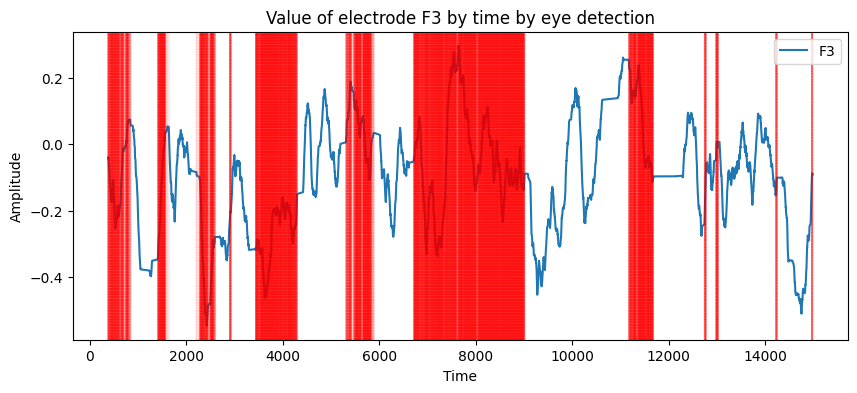

In [38]:
time = filtered_data_ma.index

plt.figure(figsize=(10, 4))
plt.plot(time, filtered_data_ma['F3'], label='F3')

blink_indices = filtered_data_ma[filtered_data_ma['eyeDetection'] == 1].index

for blink_index in blink_indices:
    plt.axvline(x=blink_index, color='red', linestyle='--', lw=0.1)

plt.title('Value of electrode F3 by time by eye detection')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

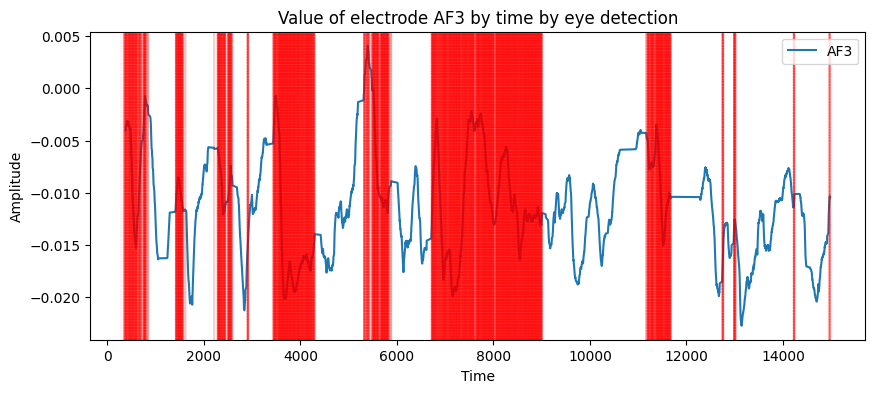

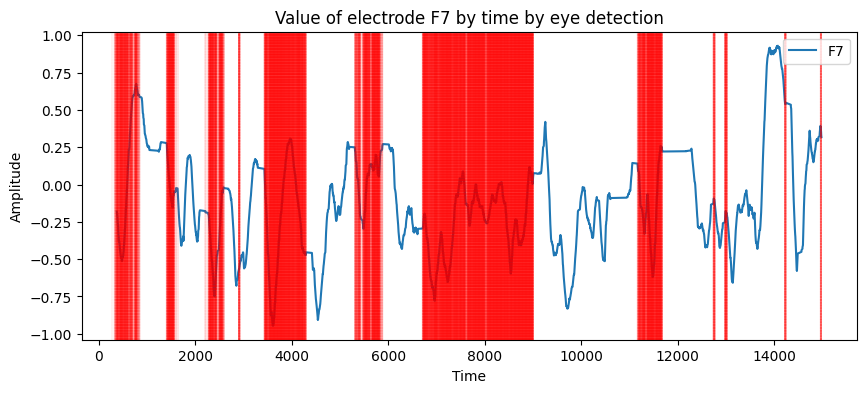

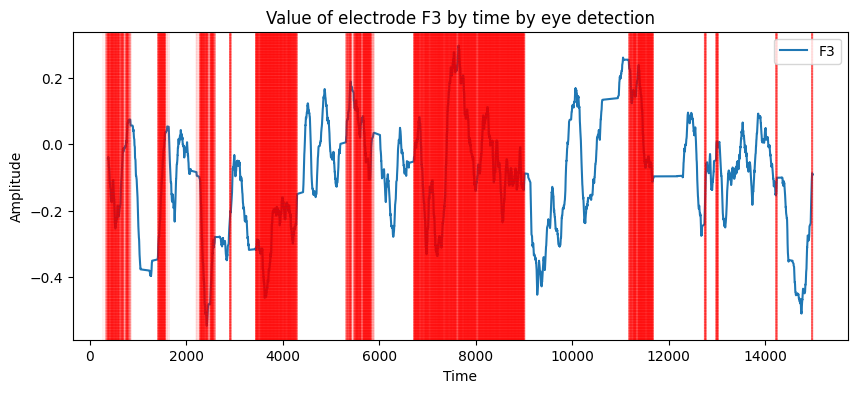

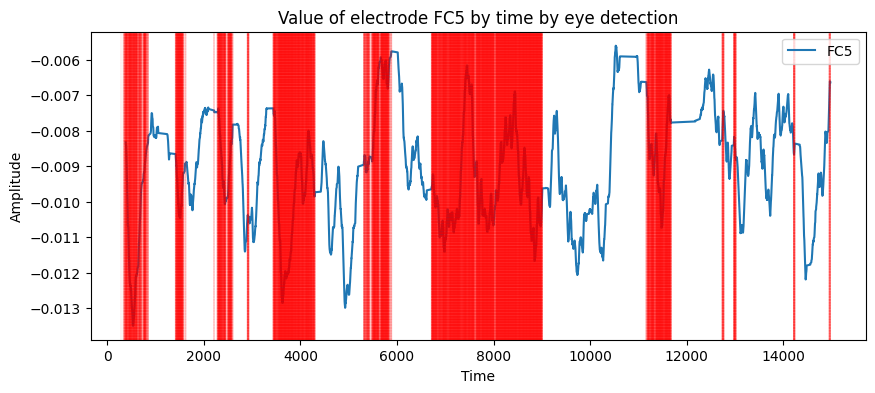

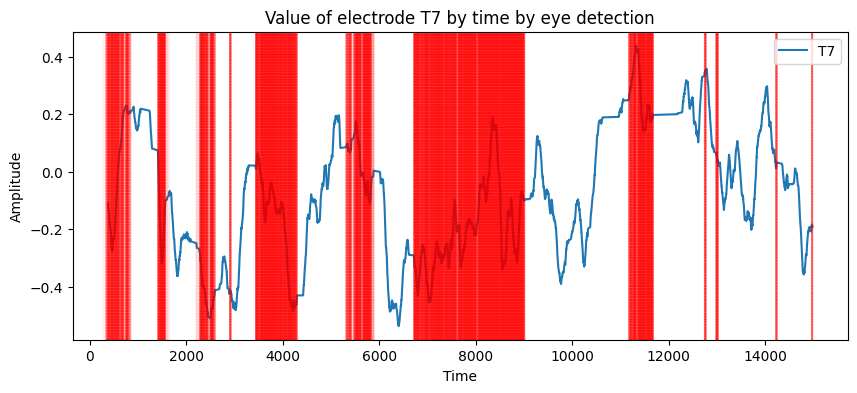

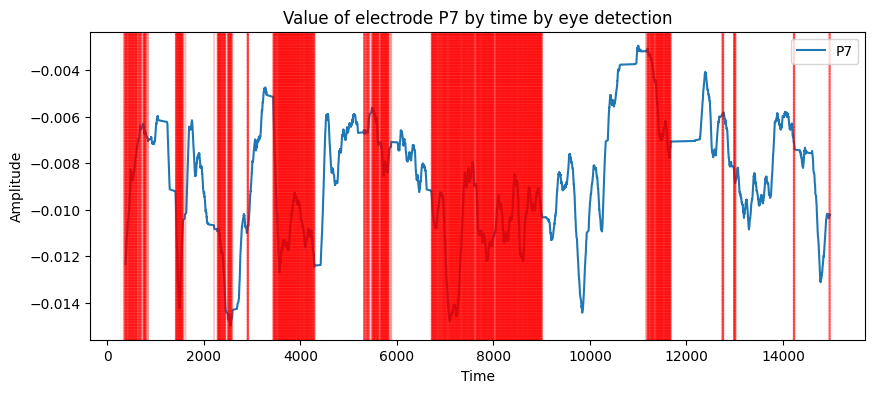

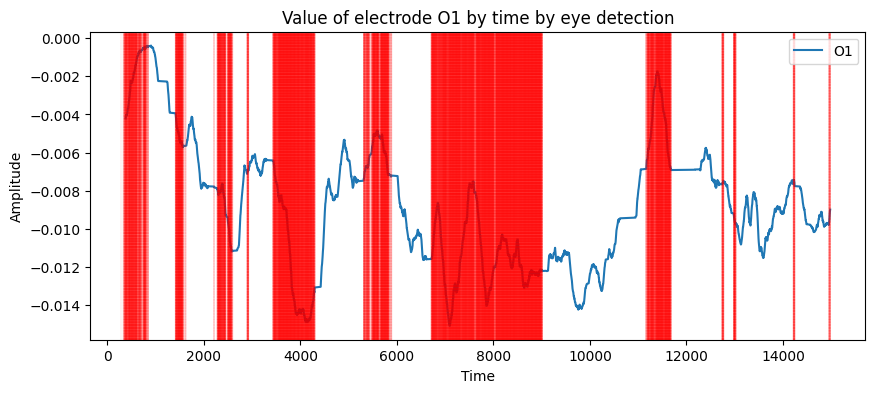

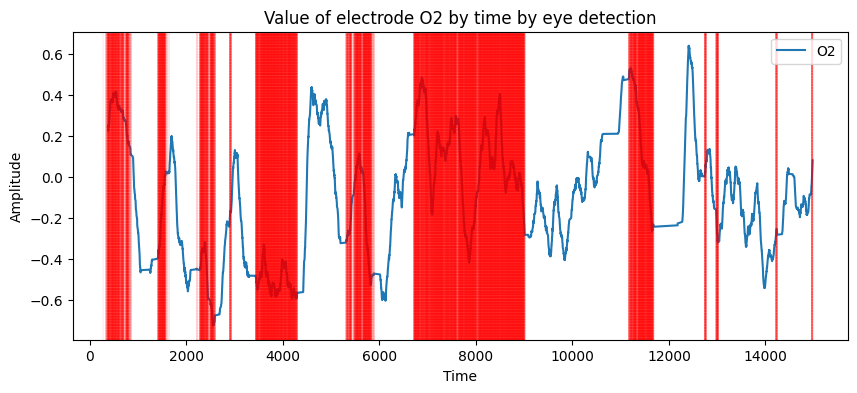

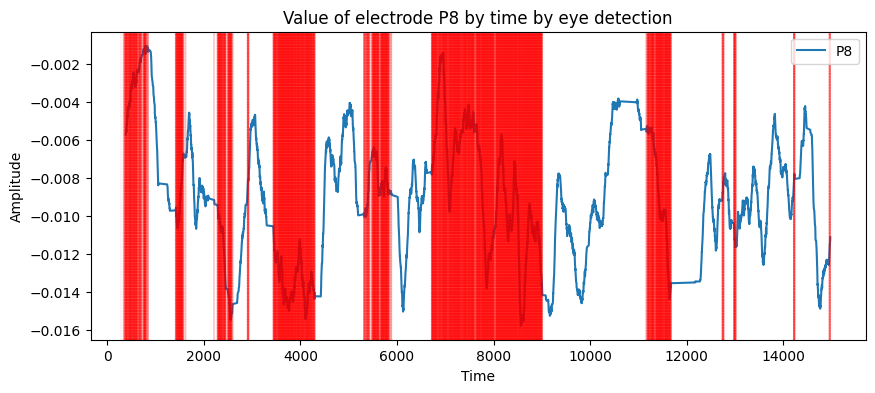

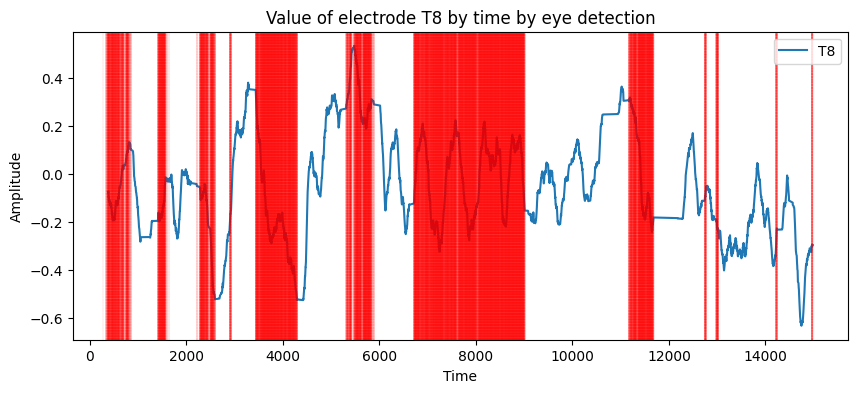

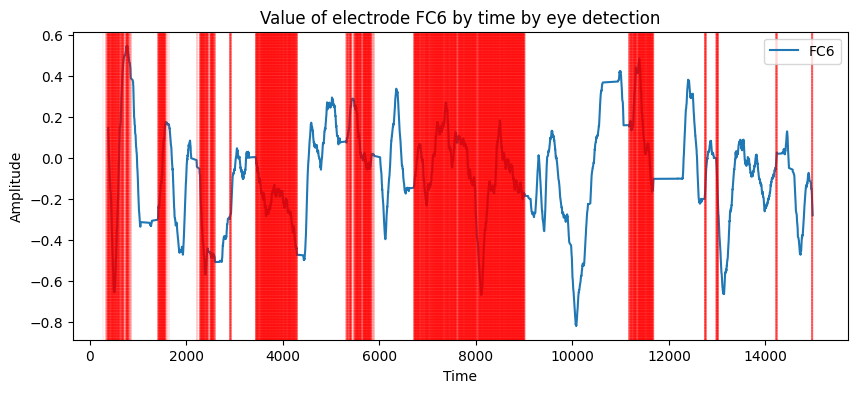

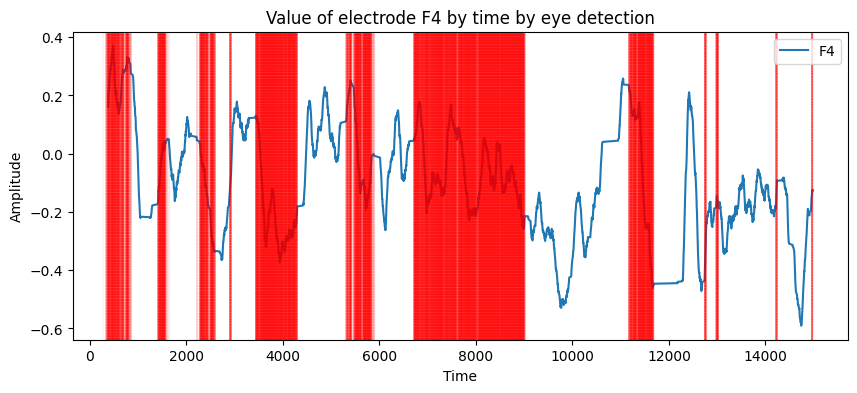

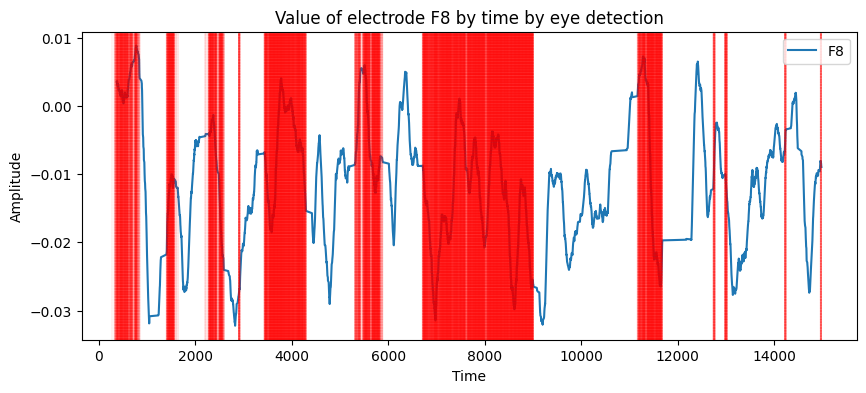

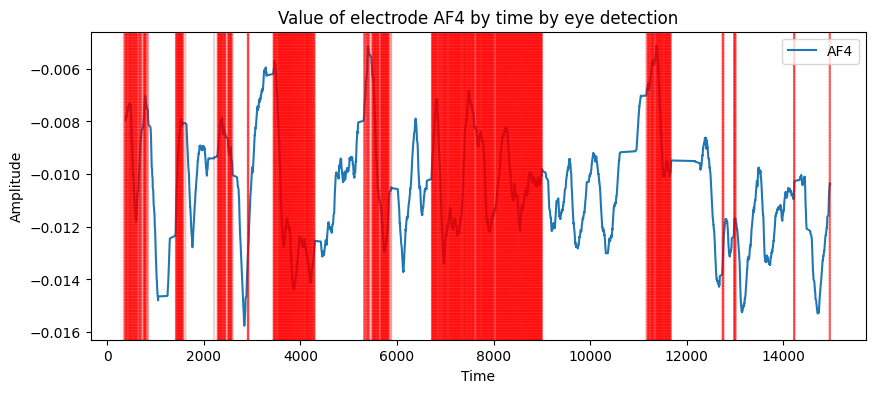

In [188]:
time = filtered_data_ma.index

for column in numeric_cols:
    plt.figure(figsize=(10, 4))
    plt.plot(time, filtered_data_ma[column], label=column)
    
    blink_indices = filtered_data_ma[filtered_data['eyeDetection'] == 1].index
    
    for blink_index in blink_indices:
        plt.axvline(x=blink_index, color='red', linestyle='--', lw=0.1)
    
    plt.title(f'Value of electrode {column} by time by eye detection')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [13]:
def butter_filter(data, cutoff, fs, order=5, filter_type='low'):
    nyq = 0.5 * fs  
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data


fs = 128
cutoff = 30 

filtered_data_all = filtered_data_ma.copy()

for column in numeric_cols:
    filtered_data_all[column] = butter_filter(filtered_data_all[column], cutoff, fs, filter_type='low')

print(filtered_data_all.head())

          AF3        F7        F3       FC5        T7        P7        O1  \
379 -0.000165 -0.007431 -0.001743 -0.000341 -0.004503 -0.000505 -0.000172   
380 -0.001039 -0.047003 -0.010953 -0.002151 -0.028519 -0.003186 -0.001086   
381 -0.002827 -0.129239 -0.029777 -0.005893 -0.078631 -0.008714 -0.002969   
383 -0.004402 -0.204878 -0.046221 -0.009291 -0.125372 -0.013699 -0.004666   
384 -0.004502 -0.216521 -0.047007 -0.009733 -0.134016 -0.014263 -0.004856   

           O2        P8        T8       FC6        F4        F8       AF4  \
379  0.009304 -0.000234 -0.003147  0.005955  0.006627  0.000144 -0.000326   
380  0.058862 -0.001477 -0.019899  0.037356  0.042068  0.000909 -0.002053   
381  0.162026 -0.004042 -0.054659  0.101421  0.116488  0.002492 -0.005617   
383  0.257839 -0.006354 -0.086345  0.157324  0.187340  0.003943 -0.008832   
384  0.275330 -0.006599 -0.090044  0.159470  0.203667  0.004168 -0.009201   

     eyeDetection  
379             1  
380             1  
381           

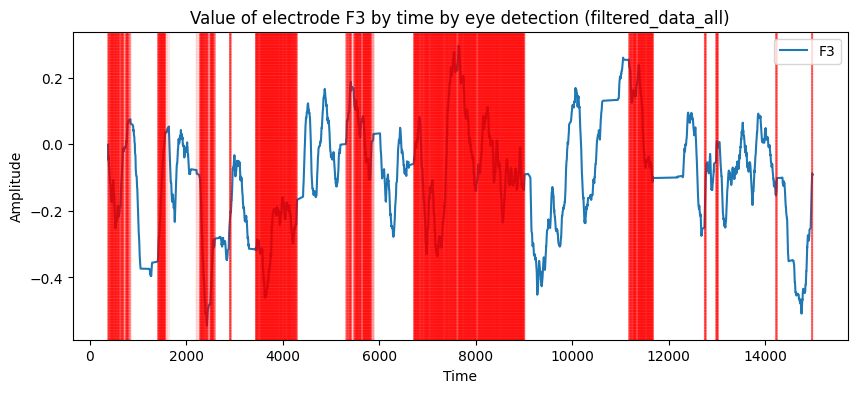

In [41]:
time = filtered_data_all.index

plt.figure(figsize=(10, 4))
plt.plot(time, filtered_data_all['F3'], label='F3')

blink_indices = filtered_data_all[filtered_data_all['eyeDetection'] == 1].index

for blink_index in blink_indices:
    plt.axvline(x=blink_index, color='red', linestyle='--', lw=0.1)

plt.title('Value of electrode F3 by time by eye detection (filtered_data_all)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Wavelet Transform

In [14]:
transformed_features = pd.DataFrame()

for column in filtered_data_all.columns.drop('eyeDetection'):
    channel_data = filtered_data_all[column].values
    coefficients, _ = pywt.cwt(channel_data, scales=np.arange(1, 128), wavelet='morl')

    mean_coefficients = coefficients.mean(axis=0)
    
    transformed_features[column] = mean_coefficients

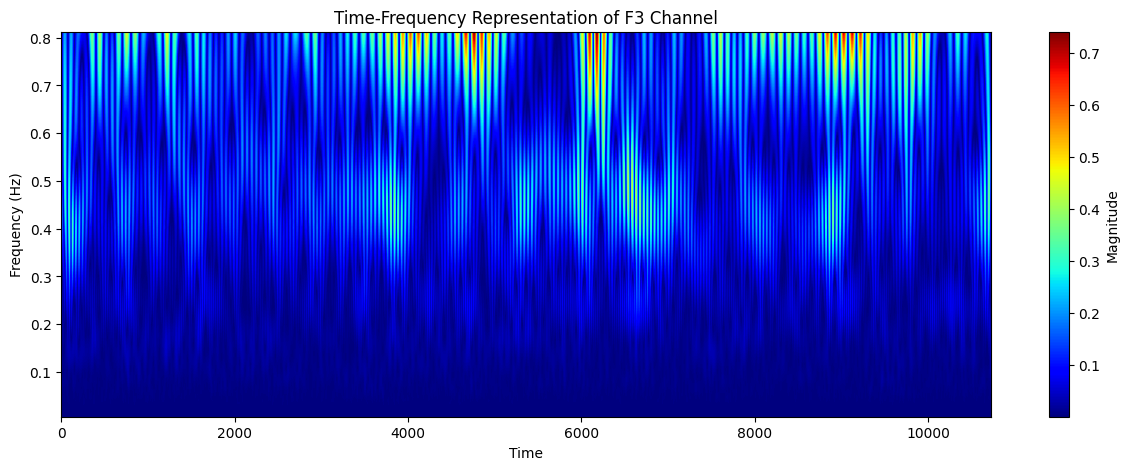

In [15]:
channel_data = filtered_data_all['F3'].values
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(channel_data, scales, wavelet='morl')

plt.figure(figsize=(15, 5))
plt.imshow(np.abs(coefficients), extent=[0, len(channel_data), frequencies.min(), frequencies.max()], cmap='jet', aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('Time-Frequency Representation of F3 Channel')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time')
plt.show()

In [43]:
transformed_features.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.001169,0.225535,0.093030,0.004102,0.128325,0.001714,0.000759,-0.159902,0.000655,0.063504,0.147745,-0.179206,0.000071,0.000991
1,-0.001698,0.206208,0.088680,0.003106,0.116968,0.000155,0.000210,-0.131853,-0.000078,0.054601,0.171754,-0.159175,0.000526,-0.000039
2,-0.002309,0.182337,0.083207,0.001925,0.102923,-0.001663,-0.000429,-0.098463,-0.000932,0.043848,0.198070,-0.135043,0.001053,-0.001238
3,-0.002948,0.156126,0.077150,0.000665,0.087523,-0.003581,-0.001103,-0.062571,-0.001832,0.032189,0.224702,-0.108744,0.001606,-0.002505
4,-0.003486,0.133374,0.071863,-0.000411,0.074285,-0.005208,-0.001678,-0.031370,-0.002596,0.022110,0.246986,-0.085366,0.002076,-0.003586


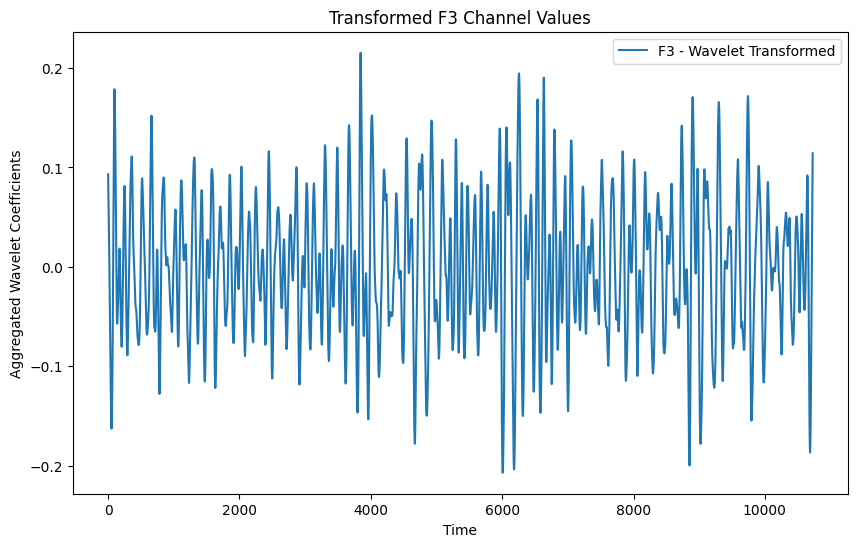

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(transformed_features['F3'], label='F3 - Wavelet Transformed')


plt.title('Transformed F3 Channel Values')
plt.xlabel('Time')
plt.ylabel('Aggregated Wavelet Coefficients')
plt.legend()
plt.show()

## Train the RNN model to predict eye state

In [16]:
transformed_features['eyeDetection'] = filtered_data_all['eyeDetection']

X = transformed_features.drop('eyeDetection', axis=1)
y = filtered_data_all['eyeDetection']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [19]:
X_train_tensor = torch.tensor(X_train.to_numpy().astype(np.float32))
y_train_tensor = torch.tensor(y_train.to_numpy().astype(np.float32).reshape(-1, 1))  #
X_test_tensor = torch.tensor(X_test.to_numpy().astype(np.float32))
y_test_tensor = torch.tensor(y_test.to_numpy().astype(np.float32).reshape(-1, 1))
X_train_tensor = X_train_tensor.unsqueeze(1) 
X_test_tensor = X_test_tensor.unsqueeze(1)  


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print(X_train_tensor.shape, X_test_tensor.shape)

torch.Size([8583, 1, 14]) torch.Size([2146, 1, 14])


In [322]:
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.5):
        super(DeepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, 
                          batch_first=True, dropout=dropout_rate)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, hn = self.rnn(x, h0)
        
        out = self.linear(out[:, -1, :])
        return out

In [342]:
input_size = X_train_tensor.shape[2]
hidden_size = 512
output_size = 1
num_layers = 3
dropout_rate = 0.5

model = DeepRNN(input_size, hidden_size, output_size, num_layers, dropout_rate)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [344]:
losses = []

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(epoch_loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/200], Loss: 0.2415
Epoch [20/200], Loss: 0.2299
Epoch [30/200], Loss: 0.2216
Epoch [40/200], Loss: 0.2088
Epoch [50/200], Loss: 0.1861
Epoch [60/200], Loss: 0.1713
Epoch [70/200], Loss: 0.1559
Epoch [80/200], Loss: 0.1404
Epoch [90/200], Loss: 0.1347
Epoch [100/200], Loss: 0.1257
Epoch [110/200], Loss: 0.1169
Epoch [120/200], Loss: 0.1136
Epoch [130/200], Loss: 0.1087
Epoch [140/200], Loss: 0.0989
Epoch [150/200], Loss: 0.0914
Epoch [160/200], Loss: 0.0830
Epoch [170/200], Loss: 0.0754
Epoch [180/200], Loss: 0.0687
Epoch [190/200], Loss: 0.0651
Epoch [200/200], Loss: 0.0588


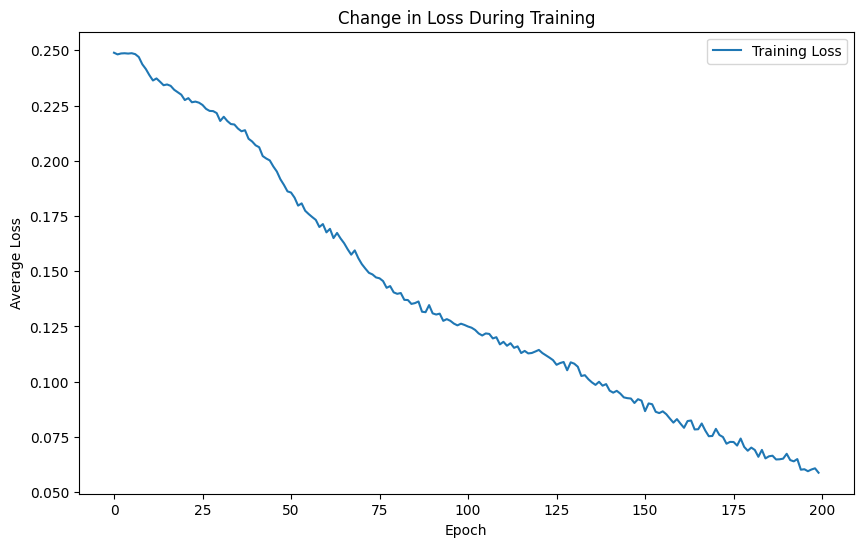

In [346]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.title('Change in Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [348]:
model.eval()
test_loss = 0.0
total = 0
predictions = []
true_labels = []

with torch.no_grad(): 
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)

        predicted = outputs.squeeze().cpu().numpy()
        predictions.extend(predicted)
        true_labels.extend(targets.cpu().numpy())

test_loss /= total
predictions_np = np.array(predictions)
true_labels_np = np.array(true_labels)
print(f'Loss on test set: {test_loss:.4f}')

Loss on test set: 0.0419


In [350]:
mse = mean_squared_error(true_labels_np, predictions_np)
r2 = r2_score(true_labels_np, predictions_np)
predicted_classes = (predictions_np > 0.5).astype(int)
accuracy = accuracy_score(true_labels_np, predicted_classes)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Coefficient of Determination (R^2): {r2:.4f}")
print(f"Accuracy on the test set: {accuracy:.4f}")

Mean Squared Error (MSE): 0.0419
Coefficient of Determination (R^2): 0.8294
Accuracy on the test set: 0.9772
